Osnabrück University - Machine Learning (Summer Term 2023) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Leila Malihi

# Exercise Sheet 11

## Introduction

This week's sheet should be solved and handed in before end of **Sunday, July 2, 2023**. If you need help (and Google and other resources were not enough), ask in the StudIP forum or feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Reinforcement Learning Theory (4 points)


**a)** Weak teacher: Reinforcement learning is often described as being different from both supervised and unsupervised learning by providing a "weak teacher". Who is this "teacher" and why is she "weak"?

In supervised learning, the goal is usually to learn some target function $f$ and the supervisor (teacher) provides labeled examples $(x, f(x))$ demonstrating how values are mapped by this function.  In unsupervised learning, the goal is to understand the basic structure underlying the given data, but there is no superviser telling what to do with the data (there is of course some form of learning goal, but this is not considered to be a "teacher").

In reinforcement learning, the goal is to acquire some action policy, that is a function $\pi:\operatorname{state}\to\operatorname{action}$, but there is no teacher providing (state, action) examples. The learner can only infer the worth of an action by performing it and obtaining a reward from the environment (hence the environment can be considered a "teacher"). This teacher is weak as she does not preselect good examples for the learner but rather leaves the task of finding instructive examples to the learner.  It hence depends on the learner how much of the environment she explores.

**b)** Markov decision process: Reinforcement learning is usually restricted to first-order Markov decision processes. What does this mean and what are the practical consequences. How would the formulae change when resorting to second-order Markov decision processes?

The Markov condition says that a successor state only depends on the current state, but not on any of the previous states (essentially meaning the system is memoryless). This drastically simplifies the setting, as previous states do not have to be taken into account when planing future actions.

Being a second-order Markov process means, that the successor state (and also the reward) does not only depend on the current state and action ($s_{t+1}=\delta(s_t,a_t)$) but also the on the previous state ($s_{t+1}=\delta(s_t,a_t,s_{t-1},a_{t-1})$). Hence also the Q-function would take four instead of two arguments.

**c)** The Q-function: The Q-function can be written as $Q(s,a) = r(s,a) + \gamma \operatorname{max}_{a'} Q(\delta(s,a),a')$.
Explain this function in your own words. What does the Q-value represent? What is the problem with that formula and how is this problem resolved in Q-learning? How would you represent this function when implementing Q-learning?

The Q-function quantifies the cumulative reward for taking action $a$ in state $s$ and afterwards following the optimal action policy.  If this function is known, a simple action policy can be devised: in state $s$ always take the action $a$ that maximizes the Q(s,a) value.

The formula is problematic though, due to its recursive structure: to compute $Q(s,a)$ one has to compute $Q(\delta(s,a),a')$, etc. There is no closed form solution for this equation. The idea of Q-learning is to find an approximation, by iteratively updating the $Q(s,a)$ values for a given pair $(s,a)$ and reward $r(s,a)$. A straight forward implementation of the algorithm would store the Q-function in a 2-dimension array (States x Actions).

**d)** Goal state: In game playing there often is a goal state (game won/lost), and so is in the maze example from the lecture slides. Discuss the role of this goal state for the Q-Learning algorithm. Describe a learning scenario without a goal state.

In many scenarios, the goal state is the only state that provides a non-trivial (non-zero) reward. This makes the (naive) Q-learning algorithm from the slides quite inefficient, as Q-values are only propagated to the direct neighboring state, requiring many runs to fill the Q-matrix. 

Q-learning does not require a goal state. It can (and actually is intended to) operate in a continuous setting, where the agent repeatedly performs actions and receives rewards from the environment. A famous example is a robot learning to balance a stick. In this case the actions would be to move in a specific direction and the reward would reflect the position of the stick.

## Assignment 2: Reinforcement Learning (8 points)

In this assignment you will have a look at the Q-Learning algorithm described in the lecture (ML-10 Slide 18). For this we generate a field with random rewards. A learning agent is then exploring the field and learns the optimal path to navigate through it. The code below is again filled with some ``TODO``s that should be filled by you in order to implement the Q-Learning algorithm. 

Below the code there are some questions! You also find a free-code field for a complete own implementation. You may use your own test mazes.

In [2]:
import numpy as np
import numpy.random as rand

def generate_field(x, y, num_rewards, max_reward):
    """
    Generate a random game field with rewards.
    
    Args:
        x (int):            x dimension of the field
        y (int):            y dimension of the field 
        num_rewards (int):  the number of rewards that should be randomly placed
        max_reward (int):   the maximum reward that can be placed 
        
    Returns:
        ndarray: A field with randomly initialized rewards, the rest of the 
        entries is zero
    """
    
    # Change or comment out to get different random data in each run
    np.random.seed(42)
    
    field = np.zeros((y,x), dtype=np.uint8)
    
    for i in range(num_rewards):
        field[rand.randint(y), rand.randint(x)] = rand.choice(max_reward)
    
    return field

In [3]:
%matplotlib notebook

import numpy as npelf.pos = new_po
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


class QLearning:
    """
    This class contains all the necessary methods to navigate through
    a maze or game with the help of a little bit of Q-Learning.
    """

    def __init__(self, field, actions, gamma):
        """
        Initializes the QLearning Algorithm with the necessary parameters.
        All q values are stored in self.q - this is an array that has
        ACTIONS x map_x x map_y dimensions to store a value for each action
        in each field. The starting position self.pos is randomly initialized.
        
        Args:
            field (ndarray):  the map
            actions (list):   the available actions
            gamma (float):    the gamma in the lecture slides
        
        Returns:
            QLearning: An instance that can be used for Q-Learning on the field
        """
        # q stores the q_values for each action in each space of the field.
        self.field = field
        self.actions = actions
        self.gamma = gamma
        
        # Remember the map extend for further navigation.
        self.map_y = self.field.shape[0]
        self.map_x = self.field.shape[1]
        
        # Create q value matrix.
        self.q = np.zeros((len(self.actions), self.map_y, self.map_x))

        # Start on a random position in the field.
        self.pos = [np.random.randint(self.map_y), np.random.randint(self.map_x)]
        self.fig, self.axes = plt.subplots(3, 3, num='QLearning State')
        for ax in self.axes.flat:
            ax.axis('off')

    def get_coordinates(self, position, action):
        """
        Returns the coordinates that follow a certain action, depending
        on the current position of the learner. If the border is reached
        the agent just stops there.
        
        Args:
            position (pair):  the current position
            action (string):  the action that should be performed (one of: 'up', 'down', ...)
            
        Returns:
            pair of int: the updated coordinates
        """elf.pos = new_po
        # return the right new coordinates dlen(self.actions)epending on the position
        ### BEGIN SOLUTION
        y_new = position[0]
        x_new = position[1]

        if action == 'left':  
            x_new -= 1 if x_new > 0 else 0
        elif action == 'right': 
            x_new += 1 if x_new < self.map_x - 1 else 0            
        elif action == 'up':    
            y_new -= 1 if y_new > 0 else 0                
        elif action == 'down':  
            y_new += 1 if y_new < self.map_y - 1 else 0
        else: 
            raise ValueError('No such action: {}'.format(action))

        return (y_new, x_new)
        ### END SOLUTION


    def update(self):
        """
        Implementation of the update step. Closely follows the Algorithm described on
        ML-10 Sl.18. Note that you have attributes available as specified in the
        __init__ method of this class, in addition to that is the FIELD variable that
        stores the real field the agent is iterating about, as well as ACTIONS which
        stores the available actions.
        """
        # Select a random action that should be performed next.
        # Be careful to handle the case where you hit the wall!
        ### BEGIN SOLUTION
        choice = np.random.choice(self.actions)
        choice_idx = self.actions.index(choice)
        new_pos = self.get_coordinates(self.pos, choice)
        # Step out when we hit a wall.
        if new_pos == self.pos: 
            returnelf.pos = new_po
        ### END SOLUTION

        # Receive the reward for the new position from the field.
        ### BEGIN SOLUTION
        reward = self.field[new_pos[0], new_pos[1]]
        ### END SOLUTION
        
        # Update the q-value for the performed action.
        ### BEGIN SOLUTION
        self.q[choice_idx, self.pos[0], self.pos[1]] = \
             reward + self.gamma * max(self.q[:, new_pos[0], new_pos[1]])
        ### END SOLUTION

        # Update the position of the player to the new field.
        ### BEGIN SOLUTION
        self.pos = new_pos
        ### END SOLUTION


    def plot(self):
        """
        Plots the current state.
        """
        fs = 8
        for i, action in enumerate(self.actions):
            ax = self.axes.flat[2*i + 1]
            ax.cla()
            ax.set(title=action)
            ax.set_xticks(np.arange(self.q[i,:,:].shape[1]))
            ax.set_yticks(np.arange(self.q[i,:,:].shape[0]))
            ax.imshow(self.q[i,:,:], interpolation='None')
            for j in range(self.q.shape[1]):
                for k in range(self.q.shape[2]):
                    text = ax.text(k, j, "{:.1f}".format(self.q[i,j,k],1),
                       ha="center", va="center", color="black", fontsize=fs)
                    plt.setp(text, path_effects=[
        PathEffects.withStroke(linewidth=1, foreground="w")])

        self.fig.canvas.draw()

SyntaxError: invalid syntax (4059318865.py, line 3)

<IPython.core.display.Javascript object>


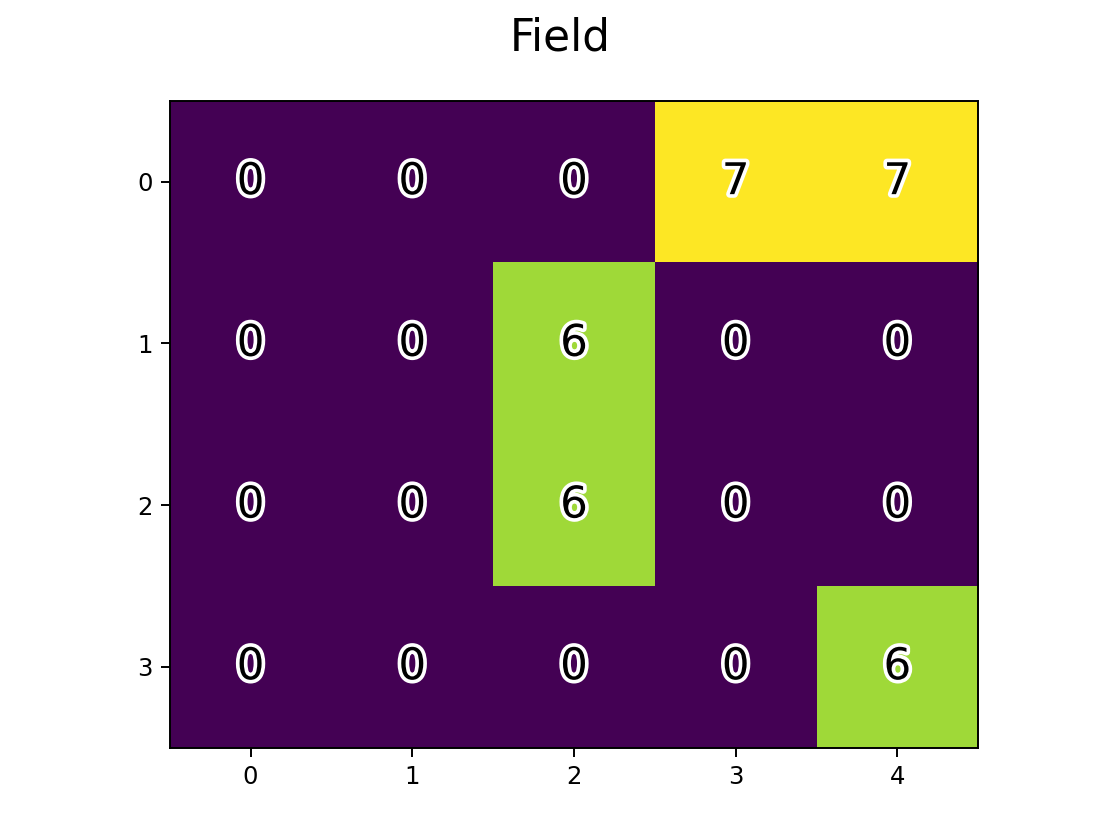

<IPython.core.display.Javascript object>


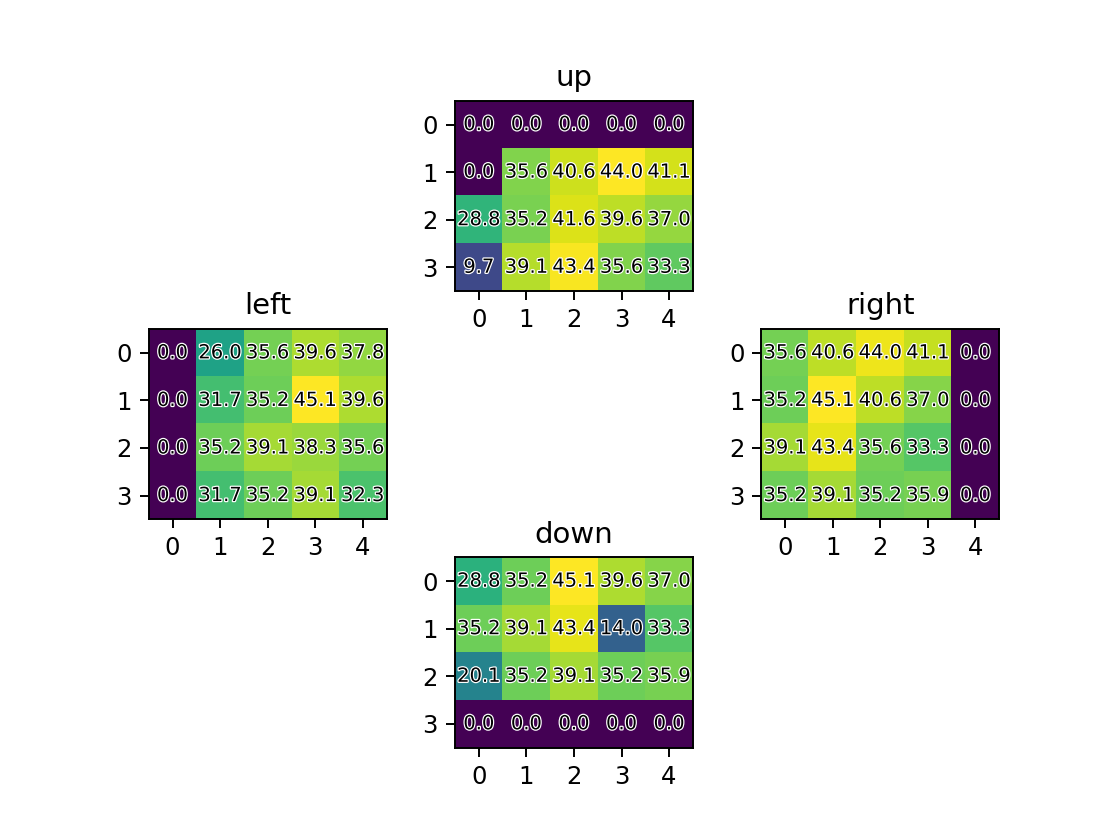

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


# Determine the size of the field, change this parameters as you like
m_x = 5
m_y = 4

steps = 500

actions = ['up','left','right','down']  # Those are the availabe actions for the QLearning.
field = generate_field(m_x, m_y, num_rewards=5, max_reward=10) # The field that is used for learning.

# Plotting the generated field
fs = 18
figure, ax = plt.subplots()
#plt.axis('off')
ax.imshow(field, interpolation='none')
ax.set_xticks(np.arange(field.shape[1]))
ax.set_yticks(np.arange(field.shape[0]))
for j in range(field.shape[0]):
    for k in range(field.shape[1]):
        text = plt.text(k, j, field[j,k], ha="center", va="center", color="black", fontsize=fs)
        plt.setp(text, path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])

figure.suptitle("Field",fontsize=fs)          
figure.canvas.draw()


# Generate a QLearning instance with the right parameters.
### BEGIN SOLUTION
player = QLearning(field, actions, 0.9)
### END SOLUTION

# Now we perform steps many learning iterations on the field with
# the generated QLearning instance.
for i in range(steps):     
    player.update()
    player.plot()

Explain in your own words, how the algorithm works. What is depicted on the resulting plots. How can an action policy be derived from these data?

* The first figure shows the field or environment with the rewards of the different positions both colourcoded and given as number.
* In the four subplots of the second figure the Q-Values for the four possible actions(up, right, down, left) are shown during and after performing QLearning.  
* A simple action policy would be to always select the action with the highest Q-Value as next action. I.e. look at the four Q-Values of the four actions at the current position, select the action with highest Q-Value, and follow the action to the new position.

You are also free to write your complete own implementation of the QLearning algorithm (instead of completing the code above). Use the following cell for your implementation.

In [ ]:
### BEGIN SOLUTION
# Your code goes here:
%matplotlib notebook

import itertools

import matplotlib.pyplot as plt
import numpy as np

maze = np.array([[0, 0, .5, 0, 0, 0, 0, 0, .5], 
                 [0, 0, 0, .2, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, .8, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0]])
actions = [lambda c : (c[0], c[1] + 1),
           lambda c : (c[0], c[1] - 1),
           lambda c : (c[0] - 1, c[1]),
           lambda c : (c[0] + 1, c[1])]

plt.figure('Q Learning')
plt.subplot(121).imshow(maze, interpolation='none', cmap='hot')

def move(pos, direction):
    new_pos = actions[direction](pos)
    for dim, c in enumerate(new_pos):
        if c < 0 or c >= maze.shape[dim]:
            raise ValueError('Action impossible.')
    return new_pos

# (Initialize parameters)
gamma = 0.9

# Initialize q(s, a) <- 0
q = np.zeros((np.prod(maze.shape), len(actions)))

for run in range(100):
    # Observe current state s
    position = (0, 0)
    s = np.ravel_multi_index(position, maze.shape)

    # Repeat
    for iteration in range(100):
        # Select action a
        a = np.random.randint(len(actions))
        # Execute action a (if possible)
        try:
            position = move(position, a)
        except ValueError:
            continue
        # Receive reward r
        r = maze[position]
        # Observe new state s_n
        s_n = np.ravel_multi_index(position, maze.shape)

        # Update q(s, a)
        q[s, a] = r + gamma * np.max(q[s_n, :])

        # Update s
        s = s_n
    plt.subplot(122).imshow(q, interpolation='none', cmap='hot')
    plt.gcf().canvas.draw()
### END SOLUTION

## Assignment 3: Uncertainty and probability (6 points)

This exercise will focus on concepts introduced in the first part of lecture (ML-11).

**a)** Modeling uncertainty: In the lecture it is claimed that probabilities can summarize several factors:

1. missing knowledge
1. incapability to devise complete models of complex domains
1. chance

Think of an example for each of these points and explain how probabilities can be applied in modeling your example.

**b)** Inference by enumeration: Given the full joint distribution below, calculate the following:


|   -    |  toothache $\wedge$ catch| toothache $\wedge$ $\neg$catch |  $\neg$toothache $\wedge$ catch | $\neg$toothache $\wedge$ $\neg$catch |
|---|---|---|---|---|
| cavity  | 0.108 | 0.012 | 0.072 | 0.008 |
| $\neg$cavity | 0.016 | 0.064 | 0.144 | 0.576 |


1. $P(\neg \text{toothache})$
1. $P(\text{cavity})$
1. $P(\text{toothache} \mid \text{cavity})$
1. $P(\text{cavity} \mid \text{toothache} \vee \text{catch})$

If you are familiar with `pandas` you can use the dataframe below to find the solutions. You can of course also write code without using pandas or calculate the answers manually. 

1. This asks for the probability that Toothache is false.
$$P (\neg toothache ) = 0.072 + 0.008 + 0.144 + 0.576 = 0.8$$
1. This asks for the vector of probability values for the random variable Cavity. It has two
values, which we list in the order <true, false>. First add up $0.108 + 0.012 + 0.072 +
0.008 = 0.2$. Then we have
$$P(Cavity) = \langle 0.2, 0.8\rangle.$$
1. This asks for the vector of probability values for Toothache, given that Cavity is true.
$$P(Toothache |cavity) = \langle(.108 + .012)/0.2, (0.072 + 0.008)/0.2\rangle = \langle 0.6, 0.4\rangle$$
1. This asks for the vector of probability values for Cavity, given that either Toothache or
Catch is true. First compute $P(toothache\vee catch) = 0.108 + 0.012 + 0.016 + 0.064 +
0.072 + 0.144 = 0.416$. Then
$$P(Cavity|toothache \vee catch) =
\langle(0.108 + 0.012 + 0.072)/0.416, (0.016 + 0.064 + 0.144)/0.416\rangle =
\langle 0.4615, 0.5384 \rangle$$


In [12]:
import pandas as pd
columns = pd.MultiIndex.from_product((('toothache', '¬toothache'), ('catch', '¬catch'))) 
index = ('cavity', '¬cavity')
data = [[0.108, 0.012, 0.072, 0.008],
        [0.016, 0.064, 0.144, 0.576]]
joint_distribution = pd.DataFrame(data, index, columns)
print(joint_distribution)

### BEGIN SOLUTION

# 1.
print("\n1)")
print(joint_distribution.sum().groupby(level=0).sum())

# 2.
print("\n2)")
print(joint_distribution.sum(axis='columns'))

# 3.
print("\n3)")
print(joint_distribution.loc['cavity', :].groupby(level=0).sum() / joint_distribution.loc['cavity', :].sum())

# 4. 
toothache_or_catch = joint_distribution.sum(axis='columns') - joint_distribution.loc[:, ('¬toothache', '¬catch')]
print("\n4)")
print(toothache_or_catch / toothache_or_catch.sum())

### END SOLUTION

        toothache        ¬toothache       
            catch ¬catch      catch ¬catch
cavity      0.108  0.012      0.072  0.008
¬cavity     0.016  0.064      0.144  0.576

1)
toothache     0.2
¬toothache    0.8
dtype: float64

2)
cavity     0.2
¬cavity    0.8
dtype: float64

3)
toothache     0.6
¬toothache    0.4
Name: cavity, dtype: float64

4)
cavity     0.461538
¬cavity    0.538462
dtype: float64


**c)** Conditional probability: For each of the following statements, either prove it is true or give a counterexample.
1. If P (a | b, c) = P (b | a, c), then P (a | c) = P (b | c)
1. If P (a | b, c) = P (a), then P (b | c) = P (b)
1. If P (a | b) = P (a), then P (a | b, c) = P (a | c)

1. True. By the product rule we know P (b, c)P (a|b, c) = P (a, c)P (b|a, c), which by
assumption reduces to P (b, c) = P (a, c). Dividing through by P (c) gives the result.
1. False. The statement P (a|b, c) = P (a) merely states that a is independent of b and c,
it makes no claim regarding the dependence of b and c. A counter-example: a and b
record the results of two independent coin flips, and c = b.
1. False. While the statement P (a|b) = P (a) implies that a is independent of b, it does
not imply that a is conditionally independent of b given c. A counter-example: a and b
record the results of two independent coin flips, and c equals the xor of a and b.

**d)** Independence and conditional independence


It is quite often useful to consider the effect of some specific propositions in the
context of some general background evidence that remains fixed, rather than in the complete
absence of information. The following questions ask you to prove more general versions of
the product rule and Bayes’ rule, with respect to some background evidence e:

1. Prove the conditionalized version of the general product rule:
$$P(X, Y \mid e) = P(X \mid Y, e)\cdot P(Y \mid e) .$$
1. Prove the conditionalized version of Bayes’ rule:
$$P(Y \mid X, e) = \frac{P(X \mid Y, e)\cdot P(Y \mid e)}{P(X \mid e)} $$

The basic axiom to use here is the definition of conditional probability:

1. We have
$$P(A, B|E) = \frac{P(A, B, E)}{P(E)}$$
and
$$P(A|B, E)\cdot P(B|E) = \frac{P(A, B, E)}{P(B, E)}\cdot \frac{P(B, E)}{P(E)}
=\frac{P(A, B, E)}{P(E)}$$ 
hence
$$P(A, B|E) = P(A|B, E)\cdot P(B|E)$$
1. The derivation here is the same as the derivation of the simple version of Bayes’ Rule. First write down the dual form of the conditionalized product rule, simply by switching A and B in the above derivation:
$$P(A, B|E) = P(B|A, E)\cdot P(A|E)$$
Therefore the two right-hand sides are equal:
$$P(B|A, E)\cdot P(A|E) = P(A|B, E)\cdot P(B|E)$$
Dividing through by $P(B|E)$ you get
$$P(A|B, E) = \frac{P(B|A, E)\cdot P(A|E)}{P(B|E)}$$


**e)** Naive Bayes models

Text categorization is the task of assigning a given document to one of a fixed set of
categories on the basis of the text it contains. Naive Bayes models are often used for this
task. In these models, the query variable is the document category, and the “effect” variables
are the presence or absence of each word in the language; the assumption is that words occur
independently in documents, with frequencies determined by the document category.
1. Explain precisely how such a model can be constructed, given as “training data” a set of documents that have been assigned to categories.
1. Explain precisely how to categorize a new document.
1. Is the conditional independence assumption reasonable? Discuss.

1. The model consists of the prior probability $P(Category)$ and the conditional probabilities $P(Word_i|Category)$. For each category $c$, $P(Category = c)$ is estimated as the fraction of all documents that are of category $c$. Similarly, 
$P(Word_i = true|Category = c)$ is estimated as the fraction of documents of category $c$ that contain $Word_i$.
1. Here, every evidence variable $Word_i$ is observed, since we can tell if any given word appears in a given document or not. Hence by Bayes rule we can estimate $P(Category|Word_i)$.
1. The independence assumption is clearly violated in practice. For example, the word pair "machine learning" occurs more frequently in any given document category than would be suggested by multiplying the probabilities of "machine" and "learning".


## Assignment 4: Bayes networks (4 points)

### a) Bayes networks

Explain in your own words the idea of a Bayes network. How is conditional independence represented in such a network? How can the full joint distribution be regained from such a network?

A Bayes network represents (random) variables of a model and their conditional dependencies as a directed acyclic graph. A path (single or multiple connected edges) between nodes $X$ and $Y$ indicates a dependency between these variables. Each variable is conditionally independent of all its non-descendents in the graph given the value of all its parents.

For specifying a probabilistic model described by a Bayes network, one only has to provide the conditional probabilities occuring as incoming arrows to each node, that is $P(X\mid\operatorname{parents}(X)$.
Then the joint probability of the model can be obtained as $P(X_1,\ldots,X_N) = \prod_{n=1}^{N}P(X_n\mid\operatorname{parents}(X_n))$.

### b) Independence in Bayes networks

Consider the Bayes network in (ML-11 slide 32):
1. If no evidence is observed, are Burglary and Earthquake independent? Prove this from the numerical semantics and from the topological semantics.
1. If we observe Alarm = true, are Burglary and Earthquake independent? Justify your answer by calculating whether the probabilities involved satisfy the definition of conditional independence.

1. Yes. According to (ML-11 slide 33)
\begin{align*}
  P(X_1,\ldots,X_n) = \prod_{i=1}^n P(X_i\mid\textit{Parents}(X))
\end{align*}
So numerically one can compute that in our case
\begin{align*}
  P(B,E,A,J,M) 
  & = P(B|\textit{Parents}(B))\cdot
  P(E|\textit{Parents}(E))\cdot
  P(A|\textit{Parents}(A))\cdot
  P(J|\textit{Parents}(J))\cdot
  P(M|\textit{Parents}(M)) \\
  & = P(B)\cdot
  P(E)\cdot
  P(A|B,E)\cdot
  P(J|A)\cdot
  P(M|A)
\end{align*}
To get $P(B,E)$ we can apply marginalization:
\begin{align*}
  P(B,E) 
  &= \sum_{a}\sum_{j}\sum_{m} P(B,E,a,j,m) \\
  &= \sum_{a}\sum_{j}\sum_{m} P(B)\cdot P(E)\cdot
  P(a|B,E)\cdot
  P(j|a)\cdot
  P(m|a) \\
  &= \sum_{a} P(B)\cdot P(E)\cdot
  P(a|B,E)\cdot 1 \cdot 1 \\
  &= P(B)\cdot P(E)\cdot 1
\end{align*}
This shows the independence of $B$ and $E$. Topologically $B$ and $E$ are d-separated by $A$ (i.e. any path connecting $B$ and $E$ goes through $A$).
1.  We check whether $P(B,E|a) = P(B|a)P(E|a)$. First computing $P(B,E|a)$:
\begin{align} P(B,E|a) = \alpha P(a|B,E)P(B, E)
&= \alpha
\begin{cases}
 0.29 \cdot 0.001 \cdot 0.002 & \text{if $B=b$ and $E=e$} \\
 0.94 \cdot 0.001 \cdot 0.998 & \text{if $B=b$ and $E=\neg e$} \\
 0.29 \cdot 0.999 \cdot 0.002 & \text{if $B=\neg b$ and $E=e$} \\
 0.001 \cdot 0.999 \cdot 0.998 & \text{if $B=\neg b$ and $E=\neg e$}
 \end{cases}
\\
&= \alpha
\begin{cases}
 0.0008 & \text{if $B=b$ and $E=e$} \\
 0.3728 & \text{if $B=b$ and $E=\neg e$} \\
 0.2303 & \text{if $B=\neg b$ and $E=e$} \\
 0.3962 & \text{if $B=\neg b$ and $E=\neg e$}
 \end{cases}
\end{align}
where $\alpha$ is a normalization constant. Checking $B = \neg b$ whether $P = (b, e|a) = P (b|a)\cdot P(e|a)$ we
find 
$$P(b,e|a) = 0.0008\neq 0.0863 = 0.3736 \cdot 0.2311 = P(b|a)\cdot P(e|a)$$
showing that $B$ and $E$ are not conditionally independent given $A$.

[RN, ex 14.4] 